In [102]:
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stats
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf
from scipy import optimize
from scipy.spatial import distance
import datetime
import time

Populating the interactive namespace from numpy and matplotlib


In [100]:
NTA = pd.read_csv("NTA_index.csv")

In [388]:
def trainNaiveBayesDiscrete(trainData):
    #training discrete Naive Bayes Classifier
    tY=trainData.loc[:,trainData.columns[0]]
    m=max([trainData[j][i] for j in trainData.columns[1:] for i in trainData.index]) #maximal number of classes in each feature of a training set
    #create output data structure for the probabilities - same column labels, rows correspond to values of x and there are two arrays like that for different b
    dp=[pd.DataFrame(columns=trainData.columns, index=range(1,m+1)), pd.DataFrame(columns=trainData.columns, index=range(1,m+1)),pd.DataFrame(columns=trainData.columns, index=range(1,m+1)),pd.DataFrame(columns=trainData.columns, index=range(1,m+1)),pd.DataFrame(columns=trainData.columns, index=range(1,m+1))]
    #split the training data between two labels
    ind1=tY==0
    ind2=tY==1
    ind3=tY==2
    ind4=tY==3
    ind5=tY==4

    #estimate P(y=b)  
    dp[0][trainData.columns[0]][1]=1.0*ind1.sum()/len(trainData.index)
    dp[1][trainData.columns[0]][1]=1.0*ind2.sum()/len(trainData.index)
    dp[2][trainData.columns[0]][1]=1.0*ind3.sum()/len(trainData.index)
    dp[3][trainData.columns[0]][1]=1.0*ind4.sum()/len(trainData.index)
    dp[4][trainData.columns[0]][1]=1.0*ind5.sum()/len(trainData.index)
    
    #estimate conditional probabilities P(x|y=b)
    for j in trainData.columns[1:]:
        for i in range(1,m+1):
            dp[0].loc[i,j]=1.0*(trainData[j][ind1]==i).sum()/ind1.sum();
            dp[1].loc[i,j]=1.0*(trainData[j][ind2]==i).sum()/ind2.sum();
            dp[2].loc[i,j]=1.0*(trainData[j][ind3]==i).sum()/ind3.sum();
            dp[3].loc[i,j]=1.0*(trainData[j][ind4]==i).sum()/ind4.sum();
            dp[4].loc[i,j]=1.0*(trainData[j][ind5]==i).sum()/ind5.sum();
    return dp


def classifyNaiveBayesDiscrete(classData,dp):
    #classifying using trained discrete Naive Bayes Classifier
    Y=classData[classData.columns[0]]*0 #initialize the empty array 
    for i in classData.index: #for al records to classify
        #start with the priors
        P1=dp[0][classData.columns[0]][1]; 
        P2=dp[1][classData.columns[0]][1];
        P3=dp[2][classData.columns[0]][1];
        P4=dp[3][classData.columns[0]][1];
        P5=dp[4][classData.columns[0]][1];

        #and multiply them by the corresponding conditional probabilities P(x_i|y=b)
        for j in classData.columns[1:]:
            P1=P1*dp[0][j][classData[j][i]]
            P2=P2*dp[1][j][classData[j][i]]
            P3=P3*dp[2][j][classData[j][i]]
            P4=P4*dp[3][j][classData[j][i]]
            P5=P5*dp[4][j][classData[j][i]]
    
        Y[i]=argmax([P1,P2,P3,P4,P5]) #finally for each record decide which P(y|x) is higher and choose the label
    
    return Y

## Bayes Classifier for Taxi demond prediction with weather, day of week, time of day and NTAName

In [74]:
weather = pd.read_csv('weather_data.csv')

weather = weather.iloc[:,[0,1]]

weather['date'] = pd.to_datetime(weather['date'])

weather['weather_level'] = 0

for i in weather.index:
    value = weather.ix[i]['temp']
    if value > 70:
        weather.loc[i,['weather_level']] = 4
    elif value > 55:
        weather.loc[i,['weather_level']] = 3
    elif value > 41:
        weather.loc[i,['weather_level']] = 2
    else:
        weather.loc[i,['weather_level']] = 1
        
weather = weather.drop('temp', 1)

In [223]:
def step1(name):  
    df = pd.read_csv(name)
    df = df.iloc[:,[3,-2]]
    df = df.dropna(how='any')
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], format='%y/%m/%d %H:%M:%S')
    df['date'] = pd.to_datetime(df.iloc[:,0]).dt.date
    df['hour'] = pd.to_datetime(df.iloc[:,0]).dt.hour
    df['day'] = df.iloc[:,0].dt.weekday

    df.date = pd.to_datetime(df.date)

    df = pd.merge(df, weather, how='inner', on='date')
    
    return df

In [224]:
name = ['3.csv', '6.csv', '9.csv', '12.csv']
wholedata = [0,0,0,0]

In [225]:
start = time.time()

for i,j in enumerate(name):
    wholedata[i] = step1(j)
    
time.time() - start

1087.7540800571442

In [226]:
alldata = pd.concat(wholedata)

In [398]:
alldata.shape

(43157327, 6)

In [399]:
alldata.head()

,tpep_pickup_datetime,NTAName,date,hour,day,weather_level
0,2015-03-24 13:42:22,Manhattanville,2015-03-24,13,1,1
1,2015-03-24 20:26:51,West Village,2015-03-24,20,1,1
2,2015-03-24 20:26:55,West Village,2015-03-24,20,1,1
3,2015-03-24 13:42:22,West Village,2015-03-24,13,1,1
4,2015-03-24 13:42:23,West Village,2015-03-24,13,1,1


In [400]:
df = alldata.groupby(['NTAName','hour','day','weather_level']).count()

df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df = df.iloc[:,[0,1,2,3,4]]

df.columns = ['weather_level','day of week','time of day','NTAName','demond']

In [401]:
df.shape

(18803, 5)

In [394]:
df.head()

,day of week,time of day,NTAName,demond
0,1,3,Marble Hill-Inwood,5
1,2,10,Marble Hill-Inwood,8
2,0,3,Marble Hill-Inwood,9
3,2,16,Marble Hill-Inwood,10
4,1,2,Marble Hill-Inwood,10


In [402]:
df1 = df.sort(columns='demond')
df1 = df1.reset_index(level=0)
df1 = df1.drop('index',1)

/Users/Tianqi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [403]:
df1.shape

(18803, 5)

In [404]:
df1.head()

,weather_level,day of week,time of day,NTAName,demond
0,1,4,16,Marble Hill-Inwood,1
1,3,2,11,Marble Hill-Inwood,1
2,4,0,8,Marble Hill-Inwood,1
3,2,1,11,Marble Hill-Inwood,1
4,4,0,9,Washington Heights North,1


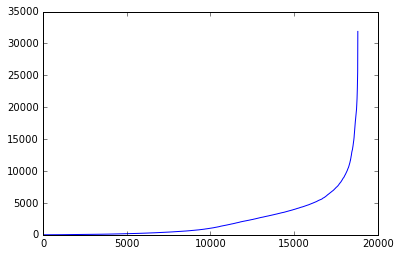

In [406]:
# plt.plot()
plt.plot(range(len(df1)),df1.demond)

In [405]:
print 18802*.25
print 18802*.5
print 18802*.75
print 18802*.90

4700.5
9401.0
14101.5
16921.8


In [261]:
mean(df1.demond)

2295.236238898048

In [339]:
print df1.iloc[4700,4]  # 25%
print df1.iloc[9401,4]  # 50%
print df1.iloc[14101,4]  # 75%
print df1.iloc[16922,4]  #90%

155
812
3360
6103


In [340]:
def clean(data):
    df = pd.merge(data, NTA, how='inner', on='NTAName')
    df = df.drop('NTAName', 1)
    df['demond_level'] = 0
    for i in df.index:
        value = df.ix[i]['demond']
        if value > 6103:
            df.loc[i,['demond_level']] = 4
        elif value > 3360:
            df.loc[i,['demond_level']] = 3
        elif value > 812:
            df.loc[i,['demond_level']] = 2
        elif value > 155:
            df.loc[i,['demond_level']] = 1
        else:
            df.loc[i,['demond_level']] = 0
    df = df.drop('demond', 1)
    
    y_train=df.iloc[:,-1] 
    X_train=df.iloc[:,:-1]
    
    train = pd.concat([y_train,X_train],axis=1)
    
    train['day of week'] = train['day of week']+1
    train['time of day'] = train['time of day']+1
    train['NTA'] = train['NTA']+1
    
    return train

In [341]:
data_train = clean(df1)

In [407]:
data_train.head()

,demond_level,weather_level,day of week,time of day,NTA
0,0,1,5,17,28
1,0,3,3,12,28
2,0,4,1,9,28
3,0,2,2,12,28
4,0,2,6,14,28


In [350]:
ind=stats.bernoulli.rvs(p = 0.75, size = len(data_train.index))
train=data_train[ind==1]
test=data_train[ind==0]

In [351]:
dp=trainNaiveBayesDiscrete(train)
dp

[   demond_level weather_level day of week time of day          NTA
 1      0.250337      0.226474    0.155612   0.0348639     0.138039
 2           NaN      0.258787    0.144841   0.0484694            0
 3           NaN      0.252268    0.146825   0.0600907            0
 4           NaN      0.262472    0.144274   0.0711451    0.0428005
 5           NaN             0    0.144841   0.0643424            0
 6           NaN             0    0.130952   0.0569728            0
 7           NaN             0    0.132653   0.0368481            0
 8           NaN             0           0   0.0311791            0
 9           NaN             0           0   0.0280612     0.138322
 10          NaN             0           0   0.0388322    0.0226757
 11          NaN             0           0   0.0396825  0.000283447
 12          NaN             0           0   0.0410998            0
 13          NaN             0           0    0.037415   0.00198413
 14          NaN             0           0   0.0

In [352]:
#run the classifier over the test sample
C=classifyNaiveBayesDiscrete(test,dp)
100.0*sum(C==test.demond_level)/len(C)

71.46496815286625

In [353]:
#also compute the accuracy over the training set
Ct=classifyNaiveBayesDiscrete(train,dp)
100.0*sum(Ct==train.demond_level)/len(Ct)

71.57454055204711

### Without Weather

In [411]:
df = alldata.groupby(['NTAName','hour','day']).count()
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df.reset_index(level=0, inplace=True)
df = df.iloc[:,[0,1,2,3]]
df.columns = ['day of week','time of day','NTAName','demond']

In [412]:
df = df.sort(columns='demond')
df = df.reset_index(level=0)
df = df.drop('index',1)

/Users/Tianqi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [413]:
df.shape

(4704, 4)

In [414]:
df.head()

,day of week,time of day,NTAName,demond
0,1,3,Marble Hill-Inwood,5
1,2,10,Marble Hill-Inwood,8
2,0,3,Marble Hill-Inwood,9
3,2,16,Marble Hill-Inwood,10
4,1,2,Marble Hill-Inwood,10


In [415]:
print 4703*.25
print 4703*.5
print 4703*.75
print 4703*.90

1175.75
2351.5
3527.25
4232.7


In [416]:
print df.iloc[1175,3]  # 25%
print df.iloc[2351,3]  # 50%
print df.iloc[3527,3]  # 75%
print df.iloc[4232,3]  # 90%

648
3246
13763
23379


In [370]:
def clean(data):
    df = pd.merge(data, NTA, how='inner', on='NTAName')
    df = df.drop('NTAName', 1)
    df['demond_level'] = 0
    for i in df.index:
        value = df.ix[i]['demond']
        if value > 23379:
            df.loc[i,['demond_level']] = 4
        elif value > 13763:
            df.loc[i,['demond_level']] = 3
        elif value > 3246:
            df.loc[i,['demond_level']] = 2
        elif value > 648:
            df.loc[i,['demond_level']] = 1
        else:
            df.loc[i,['demond_level']] = 0
    df = df.drop('demond', 1)
    
    y_train=df.iloc[:,-1] 
    X_train=df.iloc[:,:-1]
    
    train = pd.concat([y_train,X_train],axis=1)
    
    train['day of week'] = train['day of week']+1
    train['time of day'] = train['time of day']+1
    train['NTA'] = train['NTA']+1
    
    return train

In [371]:
data_train_1 = clean(df)

In [417]:
data_train_1.head()

,demond_level,day of week,time of day,NTA
0,0,2,4,28
1,0,3,11,28
2,0,1,4,28
3,0,3,17,28
4,0,2,3,28


In [374]:
ind=stats.bernoulli.rvs(p = 0.75, size = len(data_train_1.index))
train=data_train_1[ind==1]
test=data_train_1[ind==0]

In [375]:
dp=trainNaiveBayesDiscrete(train)
dp

[   demond_level day of week time of day         NTA
 1      0.253481    0.147982   0.0381166    0.149103
 2           NaN    0.137892   0.0493274           0
 3           NaN    0.158072   0.0538117           0
 4           NaN    0.144619   0.0627803   0.0403587
 5           NaN    0.146861   0.0695067           0
 6           NaN    0.131166   0.0661435           0
 7           NaN    0.133408   0.0358744           0
 8           NaN           0   0.0336323           0
 9           NaN           0   0.0302691    0.142377
 10          NaN           0   0.0369955   0.0134529
 11          NaN           0    0.044843           0
 12          NaN           0   0.0403587           0
 13          NaN           0   0.0369955           0
 14          NaN           0   0.0369955           0
 15          NaN           0   0.0358744           0
 16          NaN           0   0.0325112   0.0179372
 17          NaN           0   0.0470852           0
 18          NaN           0   0.0381166   0.0

In [376]:
#run the classifier over the test sample
C=classifyNaiveBayesDiscrete(test,dp)
100.0*sum(C==test.demond_level)/len(C)

77.21518987341773

In [377]:
#also compute the accuracy over the training set
Ct=classifyNaiveBayesDiscrete(train,dp)
100.0*sum(Ct==train.demond_level)/len(Ct)

77.49360613810742

### Demo

In [418]:
NTA

,NTA,NTAName
0,0,Manhattanville
1,1,West Village
2,2,Clinton
3,3,Central Harlem South
4,4,Midtown-Midtown South
5,5,Turtle Bay-East Midtown
6,6,Lenox Hill-Roosevelt Island
7,7,Hudson Yards-Chelsea-Flatiron-Union Square
8,8,Hamilton Heights
9,9,Lower East Side


In [387]:
demo = pd.DataFrame({'a': [0], #demond_level
                      'b': [1], #day of week
                      'c': [22], #time of day 
                      'd': [26] #NTA
                     })
demo.columns = ['demond_level', 'day of week', 'time of day', 'NTA']

demo

,demond_level,day of week,time of day,NTA
0,0,1,22,26


In [419]:
a = classifyNaiveBayesDiscrete(modle, dp)[0]
print 'The predicted Taxi demond level is:', a

The predicted Taxi demond level is: 3
